# **Install & Import Dependencies**

## 📦 Setup: Install and Import Libraries

In this cell, I install key libraries required for churn prediction, including:
- `imbalanced-learn` to handle class imbalance using SMOTE
- `xgboost` for gradient boosting models
- Core libraries: pandas, NumPy, matplotlib, seaborn
- Scikit-learn modules for model building and evaluation

This setup prepares the notebook for end-to-end ML workflows.


In [1]:
#  Environment & Imports

# Install extra libraries (only needed once per session)
!pip install -q imbalanced-learn xgboost

# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# For handling imbalance (SMOTE etc.)
from imblearn.over_sampling import SMOTE

# Gradient boosting model
from xgboost import XGBClassifier

print("✅ Imports successful!")
print("pandas version:", pd.__version__)
print("numpy version :", np.__version__)


✅ Imports successful!
pandas version: 2.2.2
numpy version : 2.0.2


# **Load Dataset from IBM GitHub**

## 📥 Load Telco Customer Churn Dataset

The dataset is pulled directly from IBM’s GitHub repository. It contains:
- 7,032 rows (each a customer)
- 21 columns (demographics, services, payments, and churn)

We check the shape and preview a few rows.


In [2]:
# Download Telco Customer Churn Dataset

import pandas as pd

dataset_url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

# Load dataset
df = pd.read_csv(dataset_url)

print("✅ Dataset Loaded Successfully!")
print("Shape of dataset:", df.shape)

# Show first few rows
df.head()


✅ Dataset Loaded Successfully!
Shape of dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **Data Overview & Quality Checks**

## 🔍 Data Summary & Initial Inspection

Here, I examine:
- Column names and data types
- Null value counts
- Descriptive statistics for numeric features
- Churn distribution (target variable)

This gives a sense of dataset cleanliness and potential issues.


In [3]:
# Basic Data Understanding (Columns, Info, Missing, Stats)

print("🔍 Dataset Columns:")
print(df.columns.tolist())

print("\n📊 Data Types:")
print(df.dtypes)

print("\n🧩 Missing Values per Column:")
print(df.isnull().sum())

print("\n📈 Summary Statistics for Numerical Columns:")
print(df.describe())

print("\n🔍 Target Variable Distribution (Churn):")
print(df['Churn'].value_counts())
print("\nPercentage Distribution:")
print(df['Churn'].value_counts(normalize=True) * 100)


🔍 Dataset Columns:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

📊 Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

🧩 Missing Values per Column:
customerID

# **Data Cleaning — Fix TotalCharges**

## 🧹 Data Cleaning: Fix `TotalCharges` Column

- Some values in `TotalCharges` are empty strings (should be floats)
- Replace empty strings with `NaN`, convert to float
- Drop 11 corrupted rows with missing `TotalCharges`

This ensures our numeric fields are ready for modeling.


In [4]:
# Data Cleaning - Fix TotalCharges Column

# Replace blank spaces with NaN
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)

# Convert to float
df['TotalCharges'] = df['TotalCharges'].astype(float)

# Remove rows with missing TotalCharges (very few)
df = df.dropna(subset=['TotalCharges'])

print("✅ TotalCharges cleaned and converted to float!")
print("New shape after cleaning:", df.shape)

# Check data types again
df.dtypes


✅ TotalCharges cleaned and converted to float!
New shape after cleaning: (7032, 21)


,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


# **Check for Remaining Issues**

## 🧪 Integrity Checks: Missing Values & Duplicates

Now that `TotalCharges` is fixed, we:
- Confirm there are no more nulls
- Check for and remove duplicates (if any)

This ensures a clean dataset before feature engineering.


In [5]:
# Data Integrity Check (Missing Values + Duplicates)

print("🔍 Checking for missing values after cleaning...\n")
print(df.isnull().sum())

print("\n🧩 Checking for duplicate rows...\n")
duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)

if duplicates > 0:
    print("⚠️ Removing duplicates...")
    df = df.drop_duplicates()
    print("Duplicates removed. New shape:", df.shape)
else:
    print("✅ No duplicate rows found!")



🔍 Checking for missing values after cleaning...

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

🧩 Checking for duplicate rows...

Duplicate rows: 0
✅ No duplicate rows found!


# **Target Distribution Plot**

## 📊 Visualize Churn Distribution

We plot a count of customers who churned vs. those who stayed.

Business Insight:
The dataset is **imbalanced** — only ~26% of customers churned.
This will be addressed using SMOTE later.


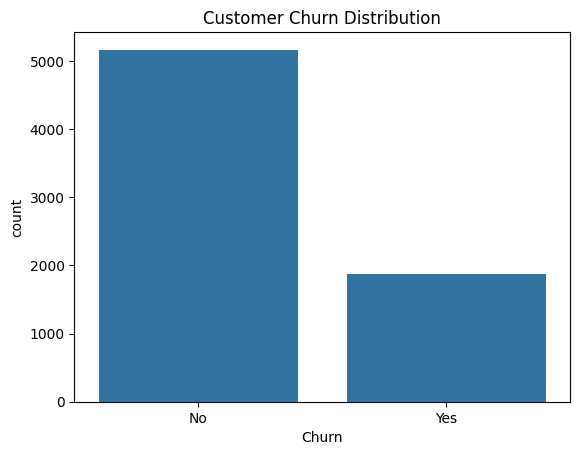


Churn counts:
Churn
No     5163
Yes    1869
Name: count, dtype: int64

Churn percentage:
Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


In [6]:
# Churn Distribution Visualization

sns.countplot(x='Churn', data=df)
plt.title("Customer Churn Distribution")
plt.show()

print("\nChurn counts:")
print(df['Churn'].value_counts())

print("\nChurn percentage:")
print(df['Churn'].value_counts(normalize=True) * 100)


# **Distribution of Numerical Features**

## 📊 Distribution of Numerical Features

In this step, I visualize the distribution of three key numeric variables:
- `tenure` (customer lifespan)
- `MonthlyCharges` (monthly bill)
- `TotalCharges` (total spend to date)

These histograms help understand:
- Skewness or outliers
- Value ranges
- Whether normalization might be needed

Understanding distributions is crucial before applying any statistical models.


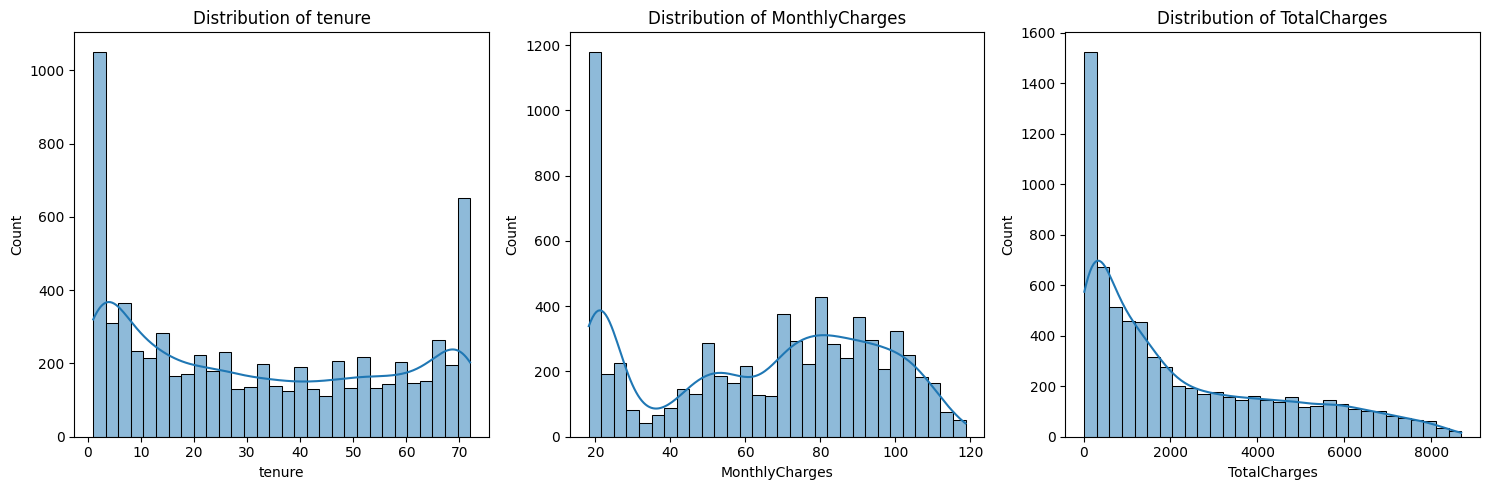

In [7]:
# Distribution of Numerical Features

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(15,5))

for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


# **Churn by Categorical Features**

## 📊 Churn Distribution Across Categorical Features

In this step, I analyze how churn varies across all major categorical features, including:
- Customer demographics (e.g., `gender`, `SeniorCitizen`, `Partner`)
- Services used (e.g., `InternetService`, `TechSupport`)
- Billing and contract features (e.g., `Contract`, `PaymentMethod`)

Each subplot shows churn vs non-churn counts for a particular category.

**Why this matters:**  
This visualization helps uncover which categorical attributes have strong influence on churn — for example:
- Month-to-month contracts usually show higher churn.
- Customers without TechSupport or OnlineSecurity often churn more.
- Payment method like Electronic check may correlate with higher risk.

These insights later guide both modeling and business recommendations.


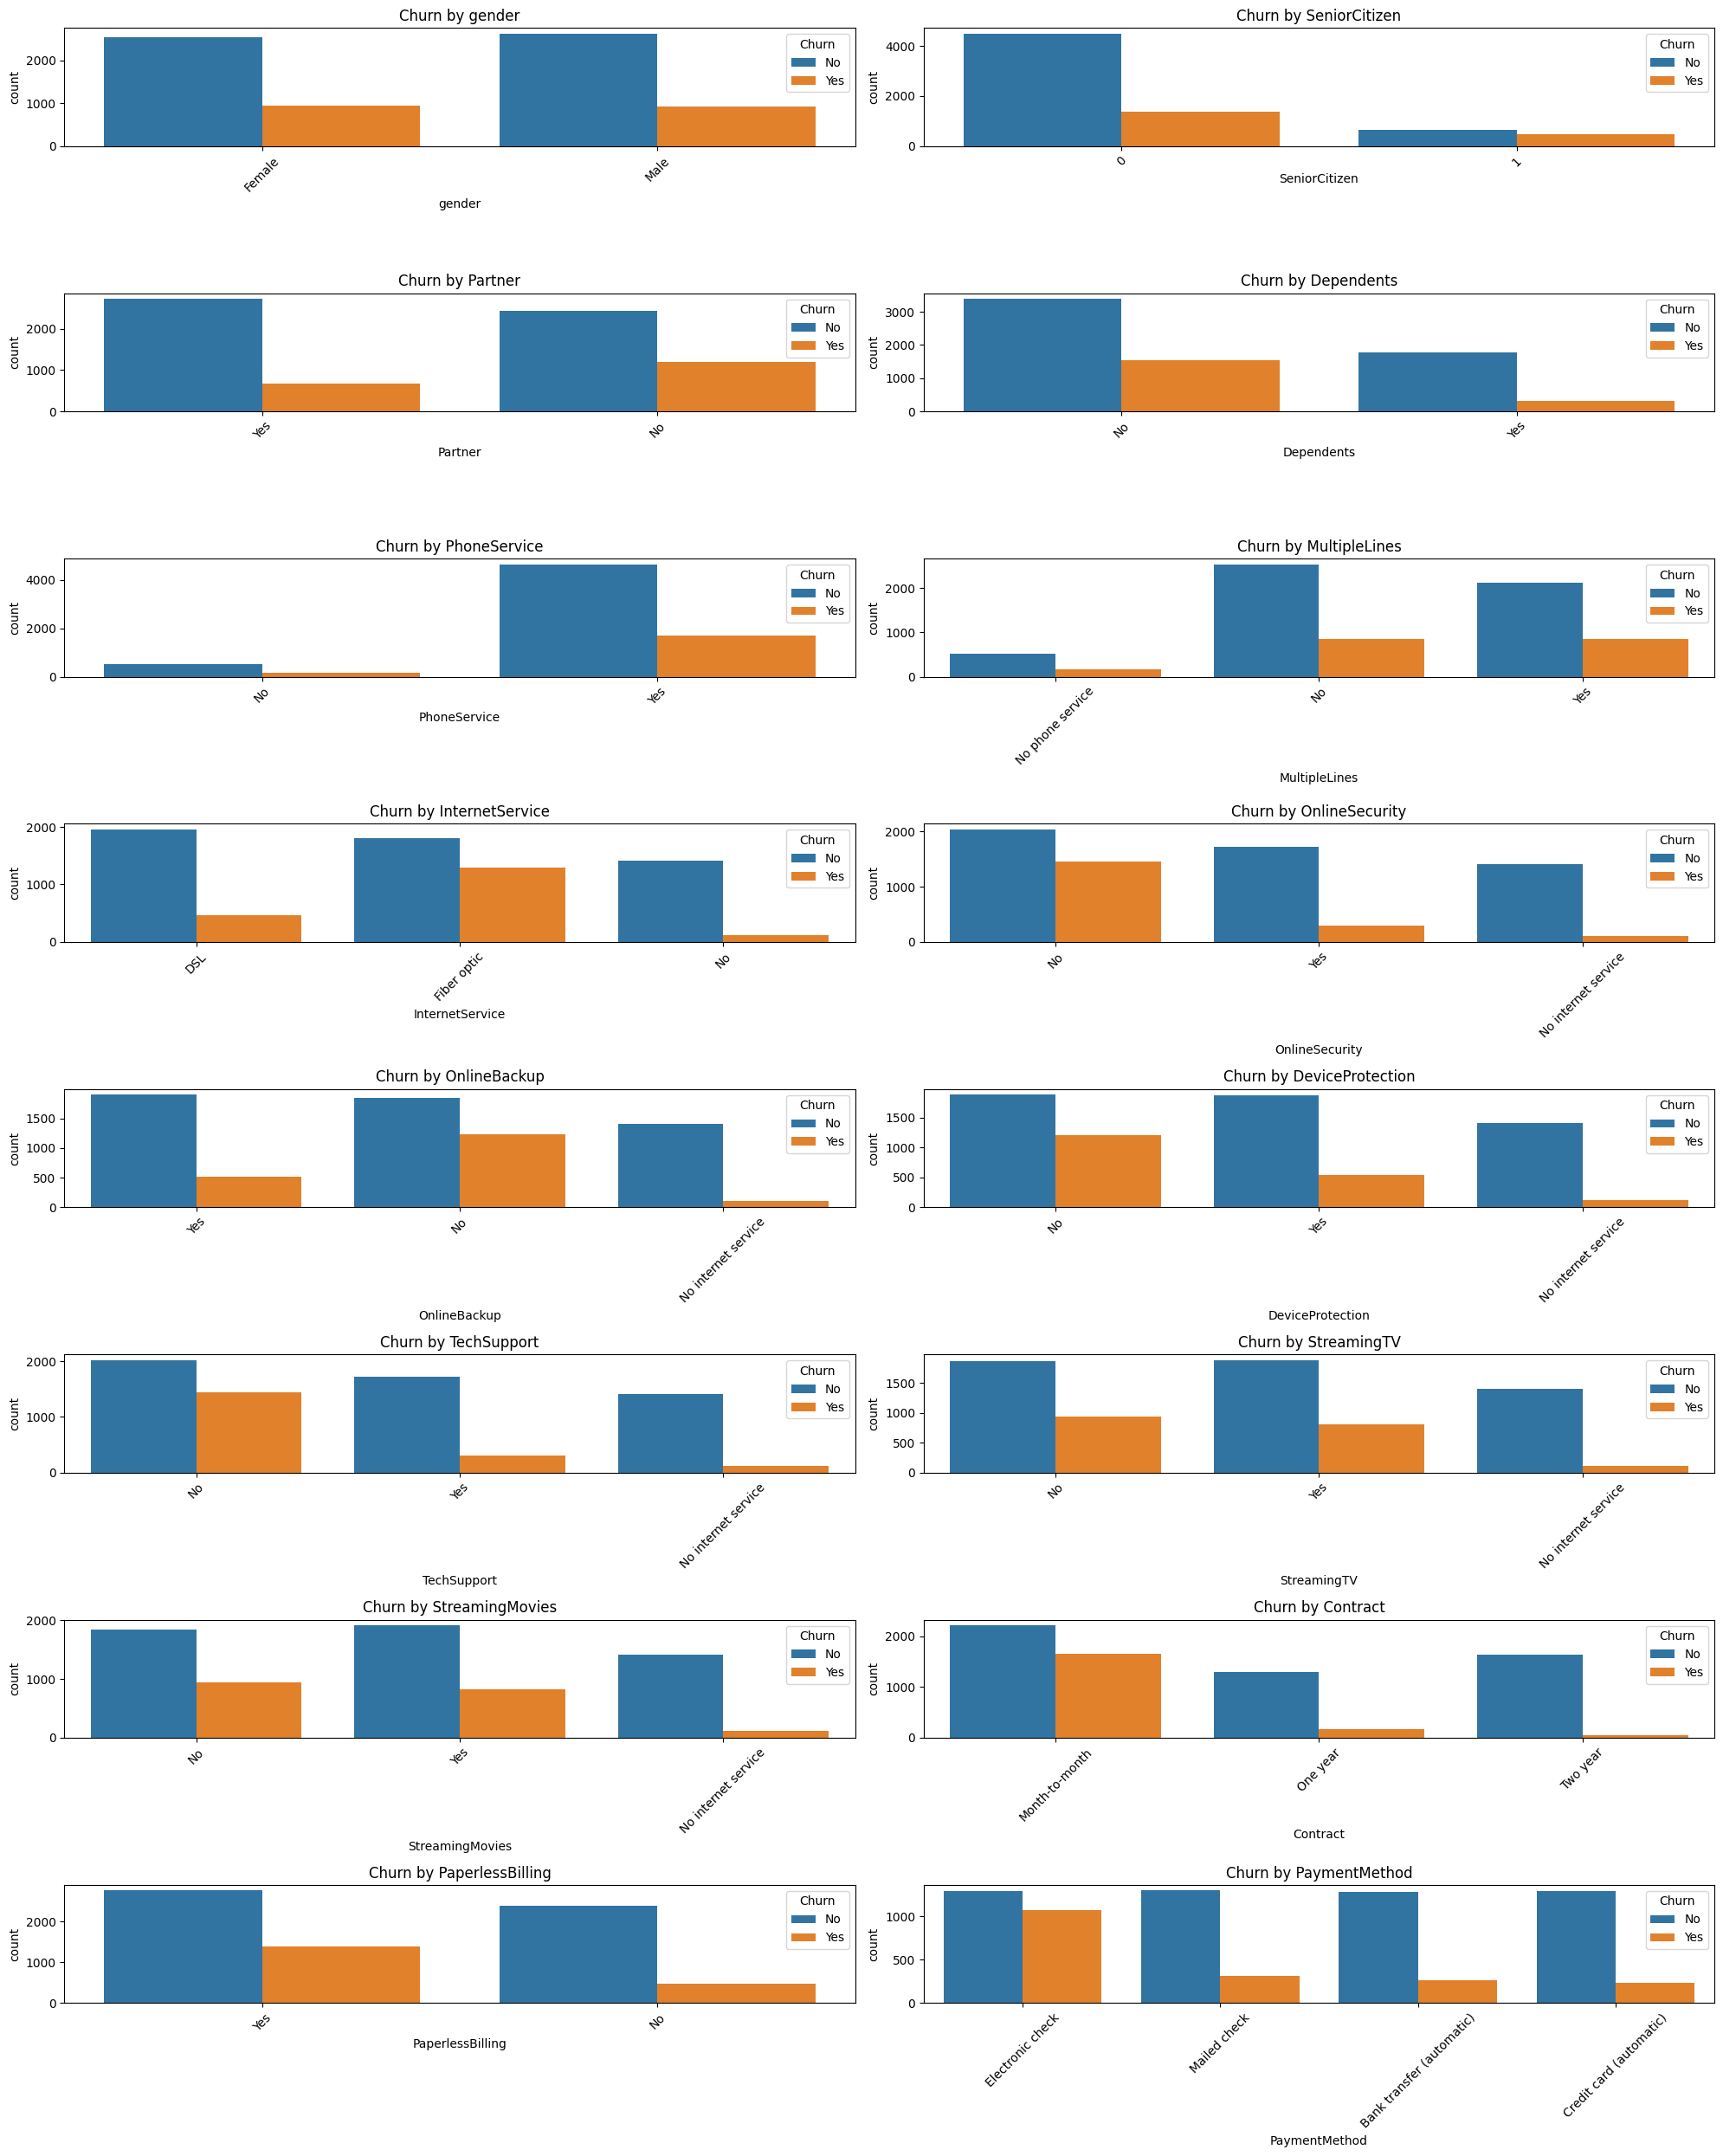

In [8]:
# Churn vs Categorical Features

categorical_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

plt.figure(figsize=(20, 25))

for i, col in enumerate(categorical_cols):
    plt.subplot(8, 2, i+1)
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f"Churn by {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# **Prepare Data for Modeling (Drop ID + Encode Target)**

## 🧼 Data Preparation for Machine Learning

In this step, I clean and prepare the data for ML modeling:

1️⃣ **Create a working copy**:  
Keep the original `df` safe for any future analysis or reference.

2️⃣ **Drop `customerID` column**:  
It’s a unique identifier with no predictive value. Removing it prevents noise in the model.

3️⃣ **Encode the target variable `Churn`**:  
Convert from string labels to numeric binary classes:  
- `'Yes'` → `1` (customer churned)  
- `'No'` → `0` (customer stayed)

This is a critical step to prepare for classification models.

📌 After this cell, the dataset (`df_model`) is ready for encoding and splitting.


In [9]:
# Prepare Data for Modeling (Drop ID + Encode Target)

# 1️⃣ Work on a copy (keep original df safe for analysis if needed)
df_model = df.copy()

# 2️⃣ Drop non-useful identifier column
df_model = df_model.drop(columns=['customerID'])

# 3️⃣ Encode target variable Churn: Yes -> 1, No -> 0
df_model['Churn'] = df_model['Churn'].map({'Yes': 1, 'No': 0})

print("✅ Prepared df_model for ML.")
print("Shape:", df_model.shape)

print("\n🔍 Churn value counts after encoding:")
print(df_model['Churn'].value_counts())

print("\nFirst 5 rows:")
df_model.head()


✅ Prepared df_model for ML.
Shape: (7032, 20)

🔍 Churn value counts after encoding:
Churn
0    5163
1    1869
Name: count, dtype: int64

First 5 rows:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


# **One-Hot Encode Categorical Features**

##  One-Hot Encode Categorical Variables

This step transforms all categorical (object-type) features into binary indicator columns using **One-Hot Encoding**.

📌 Why?
Machine learning models like Logistic Regression and Random Forest can’t handle string labels directly.  
One-hot encoding converts each category into a separate 0/1 flag so models can interpret them.

### What happens in this cell:
- Identify all categorical columns using `df_model.select_dtypes(include='object')`
- Use `pd.get_dummies()` to encode them
  - `drop_first=True` is used to avoid multicollinearity (dummy variable trap)
- The result is `df_encoded`, a fully numeric, model-ready dataset

This sets the foundation for train-test split and scaling in the next steps.


In [10]:
# One-Hot Encode Categorical Features

# Identify categorical columns (object type)
categorical_cols = df_model.select_dtypes(include=['object']).columns.tolist()

print("Categorical columns:", categorical_cols)

# Perform one-hot encoding
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

print("\n✅ One-Hot Encoding Completed!")
print("New shape after encoding:", df_encoded.shape)

# View first rows
df_encoded.head()


Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

✅ One-Hot Encoding Completed!
New shape after encoding: (7032, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


# **Train-Test Split + Feature Scaling**

## 🧪 Train-Test Split + Feature Scaling

This step prepares the data for modeling using these three actions:

---

### 1️⃣ Split Features & Target
- `X`: All features (independent variables)
- `y`: Target column (`Churn`)
- This sets up the classic supervised learning structure.

---

### 2️⃣ Create Train-Test Sets (80/20)
- I use `train_test_split` with `stratify=y` to maintain the churn ratio in both train and test sets.
- `random_state=42` ensures reproducibility.

---

### 3️⃣ Standardize Numerical Features
- I use `StandardScaler()` to normalize only numerical columns:
  - `SeniorCitizen`, `tenure`, `MonthlyCharges`, `TotalCharges`
- Scaling improves performance for models like Logistic Regression and Neural Networks.
- ⚠️ **Fit the scaler ONLY on training data**, then apply to test data — to prevent data leakage.

This results in scaled, balanced, and properly partitioned data — ready for machine learning model training.


In [11]:
# Train-Test Split + Scaling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1️⃣ Separate features and target
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

print("X shape:", X.shape)
print("y shape:", y.shape)

# 2️⃣ Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("\nTrain shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nTest shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# 3️⃣ Scaling ONLY numerical features
num_cols = ['SeniorCitizen','tenure','MonthlyCharges','TotalCharges']

scaler = StandardScaler()

# Fit on training data only (important!)
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# Apply same transformation to test data
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("\n✅ Scaling completed!")
X_train.head()


X shape: (7032, 30)
y shape: (7032,)

Train shapes:
X_train: (5625, 30)
y_train: (5625,)

Test shapes:
X_test: (1407, 30)
y_test: (1407,)

✅ Scaling completed!


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1413,-0.439319,1.321816,0.981556,1.659900,True,True,True,True,False,True,...,False,False,False,False,False,True,False,True,False,False
7003,-0.439319,-0.267410,-0.971546,-0.562252,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3355,-0.439319,1.444064,0.837066,1.756104,False,True,False,True,False,True,...,False,False,False,False,False,True,False,True,False,False
4494,-0.439319,-1.204646,0.641092,-0.908326,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
3541,-0.439319,0.669826,-0.808787,-0.101561,False,True,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False


# **Fix Class Imbalance Using SMOTE**

## ⚖️ Handle Class Imbalance with SMOTE

The churn dataset is imbalanced — only ~26% of customers have churned.  
This can lead to models that are biased toward predicting “No Churn.”

To solve this, I apply **SMOTE (Synthetic Minority Oversampling Technique)**:

---

### 🔧 What SMOTE does:
- Creates synthetic examples of the minority class (`Churn = 1`)
- Balances the classes by increasing churn samples
- Only applied to the **training set** (never test data!)

---

### ✅ Results:
- Improves model’s ability to detect churners (higher recall)
- Prevents overfitting by using synthetic data instead of simply duplicating rows

This prepares the balanced training set `X_train_resampled` and `y_train_resampled` for better churn detection performance.


In [12]:
# Fix Imbalance using SMOTE

from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply only to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("✅ SMOTE applied successfully!")
print("\nBefore SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(y_train_resampled.value_counts())

print("\nNew training shapes:")
print("X_train_resampled:", X_train_resampled.shape)
print("y_train_resampled:", y_train_resampled.shape)


✅ SMOTE applied successfully!

Before SMOTE:
Churn
0    4130
1    1495
Name: count, dtype: int64

After SMOTE:
Churn
0    4130
1    4130
Name: count, dtype: int64

New training shapes:
X_train_resampled: (8260, 30)
y_train_resampled: (8260,)


# **Logistic Regression Model**

## 🤖 Model 1: Logistic Regression (Baseline)

Logistic Regression is used as a **baseline classifier** in many churn prediction problems due to its simplicity and interpretability.

---

### ⚙️ Steps in this cell:
- Initialize a logistic regression model (`max_iter=1000` to ensure convergence)
- Train on the **SMOTE-resampled** training set
- Predict on the untouched test set
- Evaluate using:
  - `classification_report`: precision, recall, F1-score
  - `confusion_matrix`: gives a snapshot of TP/FP/TN/FN counts

---

### 🔍 Why use Logistic Regression?
- Easy to explain to business teams  
- Quick to train  
- Often performs surprisingly well with well-processed tabular data  

This model sets the benchmark against which we compare more complex models like Random Forest, XGBoost, and ANN.


In [13]:
# Logistic Regression Model

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)

# Train
log_reg.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_lr = log_reg.predict(X_test)

# Evaluate
print("📌 Logistic Regression Performance")
print(classification_report(y_test, y_pred_lr))

from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix:")
print(cm_lr)


📌 Logistic Regression Performance
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1033
           1       0.51      0.72      0.60       374

    accuracy                           0.74      1407
   macro avg       0.70      0.74      0.70      1407
weighted avg       0.78      0.74      0.75      1407


Confusion Matrix:
[[777 256]
 [105 269]]


# **Random Forest Classifier**

## 🌲 Model 2: Random Forest Classifier

Random Forest is an ensemble learning method known for its robustness and high performance on tabular datasets — especially when feature interactions matter.

---

### ⚙️ Model Configuration:
- `n_estimators=300`: number of decision trees
- `max_depth=None`: trees grow until all leaves are pure
- `class_weight=None`: not needed since SMOTE has already balanced the classes

---

### 🔁 Steps:
- Train the Random Forest on SMOTE-resampled data
- Predict churn outcomes on the test set
- Evaluate using:
  - `classification_report`: precision, recall, F1-score
  - `confusion_matrix`: for error analysis

---

### 📌 Why Random Forest?
- Can model non-linear relationships
- Handles large feature spaces and categorical flags well
- Less prone to overfitting than individual decision trees

This model is a strong candidate for production use due to its balance of accuracy, interpretability, and inference speed.


In [14]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight=None  # SMOTE already balanced this
)

# Train
rf.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_rf = rf.predict(X_test)

print("📌 Random Forest Performance")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(cm_rf)


📌 Random Forest Performance
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1033
           1       0.55      0.64      0.60       374

    accuracy                           0.77      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.78      0.77      0.77      1407


Confusion Matrix:
[[838 195]
 [133 241]]


# **XGBoost Classifier**

## ⚡ Model 3: XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is a powerful tree-based ensemble method that often performs well in structured data competitions and industry applications.

---

### ⚙️ Model Configuration:
- `n_estimators=300`: number of boosting rounds
- `learning_rate=0.05`: step size shrinkage to prevent overfitting
- `max_depth=6`: controls tree complexity
- `subsample=0.8` & `colsample_bytree=0.8`: for regularization and diversity
- `eval_metric='logloss'`: appropriate for binary classification

---

### 🔁 Steps:
- Train the XGBoost model on the SMOTE-balanced training set
- Predict churn outcomes on the real (unbalanced) test set
- Evaluate using:
  - `classification_report`: precision, recall, F1-score
  - `confusion_matrix`: helps analyze true vs. false predictions

---

### 📌 Why XGBoost?
- Handles class imbalance well
- Captures complex non-linear patterns and feature interactions
- Often outperforms other models in terms of recall and F1-score

This model is a top performer in many telecom churn use cases.


In [15]:
# XGBoost Classifier

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Train
xgb.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_xgb = xgb.predict(X_test)

print("📌 XGBoost Performance")
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("\nConfusion Matrix:")
print(cm_xgb)


📌 XGBoost Performance
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1033
           1       0.53      0.66      0.59       374

    accuracy                           0.76      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.76      0.76      1407


Confusion Matrix:
[[816 217]
 [126 248]]


# **Artificial Neural Network (ANN) for Churn Prediction**

## 🧠 Model 4: Artificial Neural Network (ANN)

This deep learning model is built using TensorFlow/Keras to predict churn.  
ANNs can learn complex patterns in data, especially when interactions between features are subtle and non-linear.

---

### ⚙️ Step-by-Step Breakdown:

#### 1️⃣ Input Preparation:
- All feature arrays (`X_train_ann`, `X_test_ann`) are converted to float32 for compatibility with Keras.
- Labels (`y_train_ann`, `y_test_ann`) are converted to int32.

#### 2️⃣ Model Architecture:
- Input layer → 64 neurons (ReLU)
- Hidden layer → 32 neurons (ReLU)
- Dropout (0.3) after each layer to prevent overfitting
- Output layer → 1 neuron with Sigmoid activation for binary classification

#### 3️⃣ Compilation:
- Optimizer: `Adam` (fast and reliable)
- Loss function: `binary_crossentropy` (standard for binary classification)
- Metric: `accuracy`

#### 4️⃣ Training:
- 30 epochs
- Batch size: 64
- 20% of training set used as validation
- SMOTE-balanced data improves learning on churned customers

#### 5️⃣ Evaluation:
- Predictions are thresholded at 0.5 to produce binary class labels
- Model evaluated using:
  - `classification_report`
  - `confusion_matrix`

---

### 📌 Why ANN?
- Can outperform traditional models when tuned well
- Especially useful for large, complex feature spaces (like after one-hot encoding)
- Learns deep representations that capture patterns not obvious to tree-based models

This ANN becomes a strong contender if we care about raw AUC or F1-score, but may be slightly harder to deploy than simpler models.


In [16]:
# Artificial Neural Network (ANN) for Churn Prediction

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# 1️⃣ Ensure all features are numeric float32 (no object/bool)
X_train_ann = X_train_resampled.astype("float32").to_numpy()
X_test_ann = X_test.astype("float32").to_numpy()

y_train_ann = y_train_resampled.to_numpy().astype("int32")
y_test_ann = y_test.to_numpy().astype("int32")

input_dim = X_train_ann.shape[1]
print("Input features for ANN:", input_dim)

# 2️⃣ Build the ANN model
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')   # Binary output (churn prob)
])

# 3️⃣ Compile the model
ann_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

ann_model.summary()

# 4️⃣ Train the model
history = ann_model.fit(
    X_train_ann,
    y_train_ann,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# 5️⃣ Evaluate on test data
y_pred_prob = ann_model.predict(X_test_ann)
y_pred_ann = (y_pred_prob > 0.5).astype(int)

print("\n📌 ANN Performance on Test Set")
print(classification_report(y_test_ann, y_pred_ann))

cm_ann = confusion_matrix(y_test_ann, y_pred_ann)
print("\nConfusion Matrix:")
print(cm_ann)


Input features for ANN: 30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6525 - loss: 0.6075 - val_accuracy: 0.6743 - val_loss: 0.7517
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7640 - loss: 0.4979 - val_accuracy: 0.7288 - val_loss: 0.6114
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7685 - loss: 0.4923 - val_accuracy: 0.7161 - val_loss: 0.6195
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7703 - loss: 0.4733 - val_accuracy: 0.7530 - val_loss: 0.5618
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7748 - loss: 0.4725 - val_accuracy: 0.7458 - val_loss: 0.5790
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7717 - loss: 0.4703 - val_accuracy: 0.7433 - val_loss: 0.5767
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7766 - loss: 0.4610 - val_accuracy: 0.7361 - val_loss: 0.5841
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7834 - loss: 0.4601 - val_accuracy: 0.

# **ROC Curves and AUC Comparison for All Models**

## 📈 ROC Curves & AUC Score Comparison

This step compares all four churn models using the **Receiver Operating Characteristic (ROC) Curve** and their corresponding **AUC (Area Under Curve)** scores.

---

### 📌 Why AUC?
- AUC summarizes how well a model distinguishes between classes at **all possible thresholds**
- Higher AUC = better model at separating churners vs. non-churners
- Especially important for imbalanced classification problems like churn

---

### ✅ What This Cell Does:
- Computes prediction probabilities for:
  - Logistic Regression
  - Random Forest
  - XGBoost
  - ANN (already computed during inference)
- Calculates `roc_auc_score` for each
- Plots ROC curves with AUC scores for side-by-side visual comparison

---

### 📊 Interpretation:
- The closer a ROC curve is to the top-left corner, the better the model
- AUC values above 0.80 are considered strong for business use cases
- This plot helps decide which model to select for production based on **balanced performance, not just accuracy**

This is a critical final evaluation step before model selection and deployment.


Logistic Regression AUC: 0.822
Random Forest AUC      : 0.814
XGBoost AUC            : 0.821
ANN AUC                : 0.835


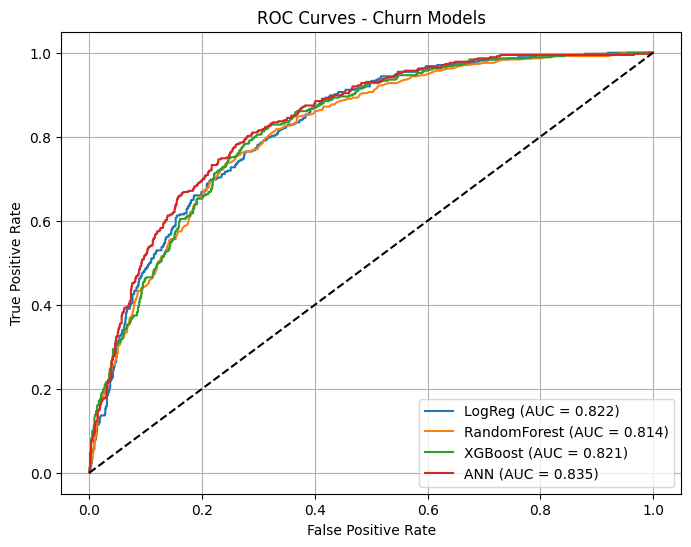

In [17]:
# ROC-AUC Comparison for All Models

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilities for classical models
y_prob_lr  = log_reg.predict_proba(X_test)[:, 1]
y_prob_rf  = rf.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# ANN probs already computed as y_pred_prob
y_prob_ann = y_pred_prob.ravel()

# Compute AUCs
auc_lr  = roc_auc_score(y_test, y_prob_lr)
auc_rf  = roc_auc_score(y_test, y_prob_rf)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
auc_ann = roc_auc_score(y_test, y_prob_ann)

print(f"Logistic Regression AUC: {auc_lr:.3f}")
print(f"Random Forest AUC      : {auc_rf:.3f}")
print(f"XGBoost AUC            : {auc_xgb:.3f}")
print(f"ANN AUC                : {auc_ann:.3f}")

# Plot ROC curves
plt.figure(figsize=(8,6))

for name, y_prob, auc in [
    ("LogReg",  y_prob_lr,  auc_lr),
    ("RandomForest", y_prob_rf, auc_rf),
    ("XGBoost", y_prob_xgb, auc_xgb),
    ("ANN",     y_prob_ann, auc_ann),
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Churn Models")
plt.legend()
plt.grid(True)
plt.show()


# **Feature Importance from Random Forest**

## 🔍 Feature Importance Analysis (Random Forest)

Random Forest provides a built-in way to measure **feature importance** — indicating how much each feature contributes to model decision-making.

---

### ✅ What This Cell Does:
- Extracts importance scores using `.feature_importances_`
- Maps them to feature names from `X_train`
- Creates a sorted DataFrame of features ranked by importance
- Plots the **Top 20 most influential features**

---

### 📊 Why Feature Importance Matters:
- Helps understand **why** the model is making certain predictions
- Reveals which customer attributes (e.g., `tenure`, `MonthlyCharges`, `Contract type`) drive churn behavior
- Supports **explainability and business trust** in ML models

This interpretability step is essential when deploying models to production — especially in telecom, where managers want to know “why is this customer predicted to churn?”


                           Feature  Importance
1                           tenure    0.177185
3                     TotalCharges    0.164390
2                   MonthlyCharges    0.144264
25               Contract_Two year    0.055899
28  PaymentMethod_Electronic check    0.055003
10     InternetService_Fiber optic    0.044698
26            PaperlessBilling_Yes    0.029194
24               Contract_One year    0.028013
4                      gender_Male    0.025193
13              OnlineSecurity_Yes    0.024887


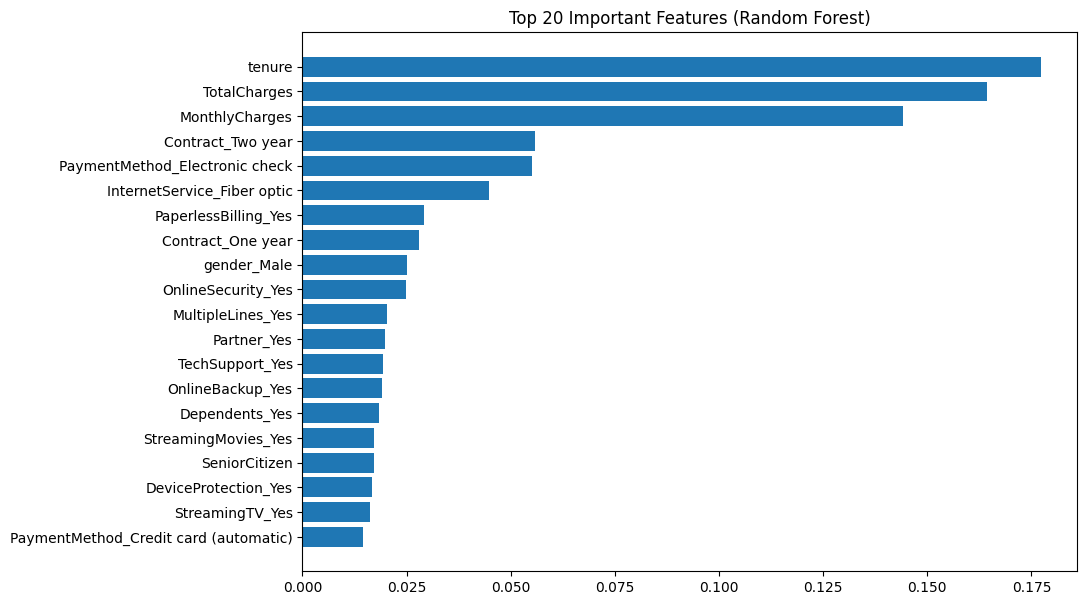

In [18]:
# Feature Importance from Random Forest

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(fi_df.head(10))

# Plot top 20 features
plt.figure(figsize=(10,7))
plt.barh(fi_df['Feature'].head(20), fi_df['Importance'].head(20))
plt.title("Top 20 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()


# **Save Model & Preprocessing Artifacts for Deployment**

## 💾 Save Trained Model and Preprocessing Artifacts

This step prepares everything needed for real-time prediction in a production environment.

---

### 📦 What’s Saved in `churn_model_artifacts.pkl`:
- ✅ Trained **Random Forest** model
- ✅ Fitted **StandardScaler** (used for numerical features)
- ✅ Column names used during training (`feature_columns`)
- ✅ Lists of:
  - Numerical columns to scale (`num_cols`)
  - Original categorical columns (used for encoding)

---

### 📌 Why Save Artifacts?
- So the same preprocessing steps (scaling, encoding) can be re-applied during inference
- Avoids retraining the model each time
- Enables use in apps like **Streamlit** or **Flask APIs**

This file is essential for making predictions in the deployed application.


In [19]:
# Save model + preprocessing artifacts for deployment

import joblib

# Make sure these exist in your session:
# rf, scaler, X_train, num_cols, categorical_cols

artifacts = {
    "model": rf,
    "scaler": scaler,
    "feature_columns": X_train.columns.tolist(),
    "num_cols": ['SeniorCitizen','tenure','MonthlyCharges','TotalCharges'],
    "categorical_cols": [
        'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
        'PaperlessBilling', 'PaymentMethod'
    ]
}

joblib.dump(artifacts, "churn_model_artifacts.pkl")
print("✅ Saved: churn_model_artifacts.pkl")


✅ Saved: churn_model_artifacts.pkl


# **Download Model Artifacts from Colab**

## ⬇️ Download Trained Model Artifacts (for Deployment)

This command allows me to download the saved `churn_model_artifacts.pkl` file from the Colab environment to my local machine.

This file can now be:
- Uploaded to an AWS EC2 instance
- Used inside a **Streamlit** or **Flask** app
- Integrated into a **CI/CD pipeline**

It contains everything needed to make predictions on new telecom customer data.


In [20]:
from google.colab import files
files.download("churn_model_artifacts.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Hyperparameter Tuning – Random Forest**

## 🔧 Hyperparameter Tuning: Random Forest (GridSearchCV)

This step performs **exhaustive hyperparameter tuning** for the Random Forest model using `GridSearchCV`.

---

### 🎯 Goal:
Improve model performance (especially F1-score) by finding the optimal combination of:
- `n_estimators`: number of trees
- `max_depth`: max tree depth
- `min_samples_split`: minimum samples to split a node
- `min_samples_leaf`: minimum samples at a leaf
- `class_weight`: handle imbalance or not (optional with SMOTE)

---

### ⚙️ Process:
- Uses 5-fold cross-validation (`cv=5`)
- Evaluates models based on **F1-score** (best for imbalanced binary problems like churn)
- Runs on all CPU cores with `n_jobs=-1`
- The best model is saved to `best_rf`

---

### 📊 Evaluation:
- Prints the best parameters
- Evaluates tuned model on test set using:
  - Classification Report (precision, recall, F1-score)
  - Confusion Matrix
  - AUC score (to compare with previous models)

---

### 📌 Why It Matters:
This step validates whether tuning improves over the **default Random Forest**, using actual business metrics (recall, AUC).  
A small performance gain might be worth the extra complexity — or not, depending on model stability and deployment constraints.


In [21]:
# Hyperparameter Tuning: Random Forest

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("\n🔧 Starting Random Forest Hyperparameter Tuning...")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train_resampled, y_train_resampled)

# ✅ Best tuned Random Forest model
best_rf = grid_rf.best_estimator_
print("✅ Best RF Params:", grid_rf.best_params_)

# 📊 Predict and Evaluate
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report (Tuned Random Forest):\n", classification_report(y_test, y_pred_rf))
print("🔁 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("📈 AUC Score:", roc_auc_score(y_test, y_prob_rf))



🔧 Starting Random Forest Hyperparameter Tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
✅ Best RF Params: {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

📊 Classification Report (Tuned Random Forest):
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1033
           1       0.55      0.66      0.60       374

    accuracy                           0.77      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.78      0.77      0.77      1407

🔁 Confusion Matrix:
 [[834 199]
 [127 247]]
📈 AUC Score: 0.8133441355068824
